# Extracting Features from an Image Dataset via Eigendecomposition
Materials for Methods 2: Digital Systems, Week 4: **Digital Images x Data Science**.    
Author: Jasper Shuoyang Zheng  


In this notebook, we'll do a **Principle Component Analysis (PCA)** on a dataset of animal faces to discover eigenfaces ("typical-faces"/ "characteristic-faces") in a animal face images dataset.  

PCA is a very common statistical procedure that transforms a large set of variables into smaller ones but preserving the most common information in the large set.

**Dataset:** We'll use a very small subset of the [Animal Faces High Quality (AFHQ)](https://github.com/clovaai/stargan-v2) Dataset as our face images dataset. The original AFHQ is an open-source dataset that has over 200k images of human faces.

## Preparation: Unzip the image folder

I have prepared the AFHQ subset in the `animal_faces_1000.zip` file, we can use the following code to unzip it.

In [ ]:
from PIL import Image
import os, os.path
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
folder_path='animal_faces_1000.zip'
import zipfile

def unzip_folder(zip_path, destination_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_path)

unzip_folder(folder_path, '')

## **Step 1:** Load all image files into a tensor

After unzipping, if you refresh the file browser, you'll see the unzipped folder `animal_faces_1000`, inside it should contain 1000 face images in `.jpg` format.

Now we'll need to load all these images into stack of image matrices: We learned how to load one image into a matrix last week, we can write a for-loop to iterate through all images in the folder and load them one-by-one.  

The following code will help us to do this, it loads all images in the folder, resize, [crop](https://www.geeksforgeeks.org/python-pil-image-crop-method/), and convert them into greyscale mode, and  into a `NumPy` array. Read through the code and try to understand the code as much as you can (feel free to ask ChatGPT to explain certain lines for you).

In [ ]:
# create an empty list of images
imgs = []

path = "./animal_faces_1000"
path = os.path.join(path,'')

size_x = 100
size_y = 120
crop_boundaries = (15, 15, 85, 105)

# supported file extension:
valid_images = [".jpg",".gif",".png",".tga"]

for i,f in enumerate(os.listdir(path)):

    # split the full filename (include the extension) to filename and its extension
    ext = os.path.splitext(f)[1]
    filename = os.path.splitext(f)[0]

    # if the file extension is not in the supported extension list, then skip it
    if ext.lower() not in valid_images:
        continue

    # open a image, resize it, convert it to greyscale ('L' refers to lightness), and then crop it
    img = Image.open(os.path.join(path,f)).resize((size_x,size_y)).convert('L').crop(crop_boundaries)

    # add the opened image to our list of image
    imgs.append(img)

    if i%100==0:
        print(f'processed {i} images')

img_data = np.array(imgs)

print(f'loaded into tensor: {img_data.shape}')

processed 0 images
processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
loaded into tensor: (1000, 90, 70)


Now we have the `img_data` variable, which is a tensor shaped (1000, 90, 70), 1000 indicates we have 1000 images, 90 indicates their height, 70 indicates their width.  

Let's display some examples in the dataset:

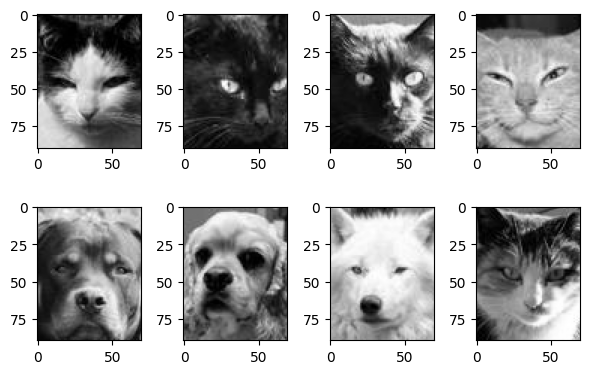

In [ ]:
# Set up the 4x2 grid for subplots
fig, axes = plt.subplots(2, 4, figsize=(6, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(img_data[i], cmap='grey')
plt.tight_layout()
plt.show()

## **Step 2:** Normalisation  

Normalisation is a technique to scale the tensor into a specific range. Now we have the image tensor with a range of 0 to 255, in data science, a common practice is to normalise all data between the range of 0 to 1.0 (as float numbers).

To do this, first, we can apply a scalar $1/255$ to our tensor.

In [ ]:
print(f'maximum number in the tensor: {img_data.max()}, \nminimum number in the tensor: {img_data.min()}')


maximum number in the tensor: 255, 
minimum number in the tensor: 0


In [ ]:
img_data = img_data * 1/255

In [ ]:
print('after normalisation:')
print(f'maximum number in the tensor: {img_data.max()}, \nminimum number in the tensor: {img_data.min()}')


after normalisation:
maximum number in the tensor: 1.0, 
minimum number in the tensor: 0.0


## **Step 3:** Subtract the mean face  

In addition, we also need to subtract a mean face from the whole dataset. The mean face is the average value of each pixel calculated from the whole dataset, by subtracting it from the entire tensor, it tells us how different each face is.

Let's start by calculating the mean face.  
In the following line, it uses NumPy's built-in mean function to calculate the average value across the first (0) axis.

In [ ]:
mean_face = img_data.mean(0)

The resulting tensor should have a shape of `(90, 70)` because the first axis has been averaged. Now we can plot the mean face tensor as an image, using the MatplotLib library.

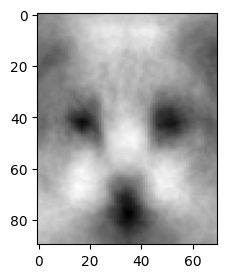

In [ ]:
plt.figure(figsize=(3,3))
# the 'cmap' parameter define thecolour scheme of the visualisation
plt.imshow(mean_face, cmap='gray')
# hide the axis
plt.axis(True)
# display the graph
plt.show()

Now we subtract this mean face from the entire face tensor to get the difference between each image and the mean, we call this the "difference tensor".  

> **Note:** Mathematically, we can only subtract tensors that have the same shape, but in the following line of code we are subtracting the `img_data` shaped (1000, 90, 70) by `mean_face` shaped (90, 70). This works fine because Python has automatically broadcasted the mean_face from (90, 70) to (1000, 90, 70). More about tensor broadcasting: [here](https://www.geeksforgeeks.org/tensor-broadcasting/)

In [ ]:
img_data = img_data - mean_face

## **Step 4:** Flatten each image into a vector  

In order to do matrix decomposition, we need to flatten our difference tensor into a matrix. Our difference tensor is currently a 3-dimensional tensor, we can flatten the width and height dimensions of it, so that we'll get a very large matrix, which has its **column repesenting the number of images**, and **row representing each pixel value**. The structure of our new difference matrix $B$ looks like this:

$B = \begin{bmatrix}
i&i&...&i\\
m&m&...&m\\
a&a&...&a\\
g&g&...&g\\
e&e&...&e\\
1&2&...&n
\end{bmatrix}$  
 .


In [ ]:
print(f'shape before flatten: {img_data.shape}')
img_data_flatten = img_data.reshape(img_data.shape[0],img_data.shape[1]*img_data.shape[2]).T
print(f'shape after flatten: {img_data_flatten.shape}')

shape before flatten: (1000, 90, 70)
shape after flatten: (6300, 1000)


Now we can see the shape of the flatten tensor is `(6300,1000)`, we have 6300 because this is the number of pixels in one image ($90\times70=6300$)

## **Step 5:** Create a correlation matrix  

Before decomposing our data matrix, we're going to do an extra step, that is to turn our data matrix to a correlation matrix. A correlation matrix $C$ is the result of the dot product between **transposed difference matrix** and the **difference matrix itself**, i.e.:  

$C=B^TB=\begin{bmatrix}
image 1\\
image 2\\
...\\
image n
\end{bmatrix} \times \begin{bmatrix}
i&i&...&i\\
m&m&...&m\\
a&a&...&a\\
g&g&...&g\\
e&e&...&e\\
1&2&...&n
\end{bmatrix}
$, resulting in shape `(1000,1000)`

And we also have the full correlation matrix $C^\prime$ which is the dot product between the **difference matrix** and the **transposed difference matrix**, i.e.:

$C^\prime=BB^T=\begin{bmatrix}
i&i&...&i\\
m&m&...&m\\
a&a&...&a\\
g&g&...&g\\
e&e&...&e\\
1&2&...&n
\end{bmatrix}\times\begin{bmatrix}
image 1\\
image 2\\
...\\
image n
\end{bmatrix}
$, resulting in shape `(6300,6300)`.  

$C$ seems much easier to solve, so we start by working with $C$ and later tranform the results to $C^\prime$.

In [ ]:
C = img_data_flatten.T.dot(img_data_flatten)

If you remember how do we calculate maxtrix $\times$ matrix multiplication (dot product), the above operation should give us a resulting matrix of size `(1000, 1000)`.

In [ ]:
print(C.shape)

(1000, 1000)


## **Step 6:** Calculate eigenvalues and eigenvectors  

### Eigenvalues and eigenvectors for correlation matrix $C$  
Now we calculate the eigenvalues $\lambda_i$ and eigenvectors $v_i$ for our correlation matrix $C$, that is, to solve all three variables in $Cv_i=\lambda_iv_i$. We can use `NumPy`'s [`eig()` funciton](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) to do this.

In [ ]:
from numpy.linalg import eig

In [ ]:
eigenvalues, eigenvectors = eig(C)

In [ ]:
print(f'eigenvalues shape: {eigenvalues.shape}')
print(f'eigenvectors shape: {eigenvectors.shape}')

eigenvalues shape: (1000,)
eigenvectors shape: (1000, 1000)


### Eigenvectors for full correlation matrix $C^\prime$  

In the lecture, we mentioned that we can derive the eigenvectors $u_i$ for the full correlation matrix $C^\prime$ by formula $u_i=Bv_i$, in which $B$ is the difference matrix, $v_i$ is the eigenvectors for correlation matrix $C$.  

In [ ]:
eigenvectors_full = img_data_flatten.dot(eigenvectors)

This will give us 1000 eigenvectors $u_i$, each has 6300 numbers, corresponding to each pixel value.

In [ ]:
print(f'ui shape: {eigenvectors_full.shape}')

ui shape: (6300, 1000)


## **Step 7:** Sort eigenvectors based on their eigenvalues

The eigenvectors corresponding to the highest eigenvalues provide the most common information about our dataset. Therefore, we can sort our eigenvectors $u_i$ based on the magnitude of their eigenvalues $\lambda_i$. We can use `NumPy`'s argsort function to get the sorted indexes of $\lambda_i$.

In [ ]:
sorted_index = np.argsort(eigenvalues)[::-1]
eigenvals_sorted = eigenvalues[sorted_index]
eigenvecs_sorted = eigenvectors_full[:,sorted_index]

Now we can cumulative sum of the eigenvalues to see how many eigenvectors capture the most information in the dataset (the image tensor).

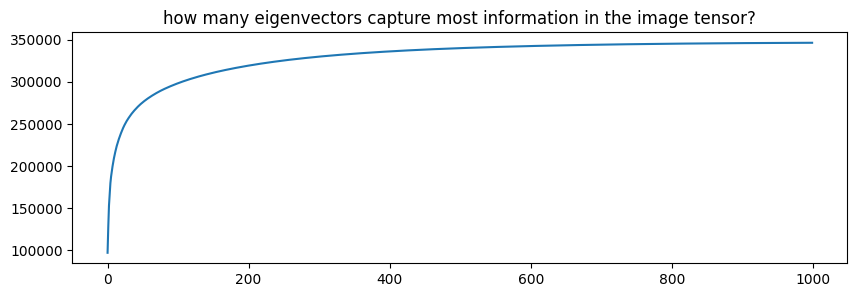

In [ ]:
cumulative_eigenvals = np.cumsum(eigenvals_sorted)

plt.figure(figsize=(10,3))
plt.plot(cumulative_eigenvals)
plt.title('how many eigenvectors capture most information in the image tensor?')
plt.show()

If we look at the plot above, we see that majority of the information is captured by roughly the first 50~100 features.

> Note: Now we got the estimation of 50~100 purely based on our observation from the plot, this fine but not the best way to do it.

## **Step 8:** Plot some eigenfaces  

We have got the sorted version of eigenvectors $u_i$, and let's only preserve the first 50 vectors because they have captured most information about our dataset.

Besides, they are now in a flatten structure (50, 6300). So now we need to reshape this flatten eigenvectors to a image tensor, they will be our **eigenfaces**.

In [ ]:
eigenvecs_sorted = eigenvecs_sorted[:,:50]
eigenfaces = eigenvecs_sorted.reshape((img_data.shape[1],img_data.shape[2],50))

Now we can plot the first 50 eigenfaces to see what are the most important features in our face dataset.

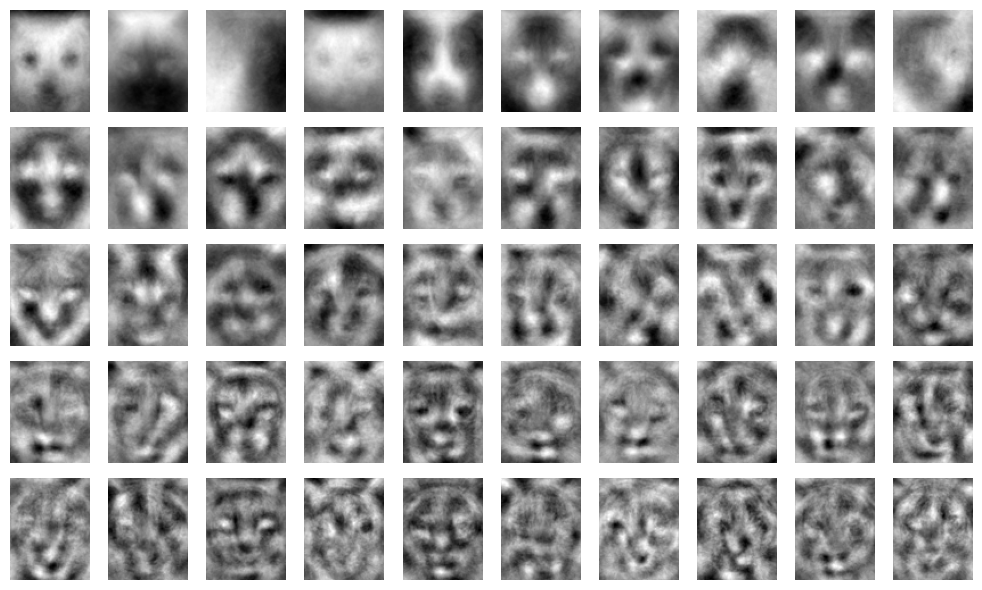

In [ ]:
# Set up the 5x10 grid for subplots
fig, axes = plt.subplots(5, 10, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[:,:,i], cmap='grey')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

**Interpretation of the results:** The first two eigenfaces present the most dominant feature of the dataset, which is the round shape of the face. From the third and the fourth eigenfaces, we can start to see the position of the eyes. Starting from the fifth eigenface, we can see the hair and face separation, and the facial elements, such as the nose and the mouth, become clearer. The seventh eigenface has an emphasis on the eye sockets. Starting from the second row, we can distinguish some facial expressions, such as smiling and neutral faces.

## Extracting new faces  

Now we can use our eigenvectors to analyse new faces, we call this process "exrtracting features from new data".  

#### Load new faces
Let's first randomly pick three faces image from the dataset and load them into tensor.

In [ ]:
new_img_1 = Image.open('./animal_faces_1000/cat_00000.jpg').resize((size_x,size_y)).convert('L').crop(crop_boundaries)
new_img_2 = Image.open('./animal_faces_1000/cat_00123.jpg').resize((size_x,size_y)).convert('L').crop(crop_boundaries)
new_img_3 = Image.open('./animal_faces_1000/dog_00155.jpg').resize((size_x,size_y)).convert('L').crop(crop_boundaries)
new_imgs = np.array([new_img_1,new_img_2,new_img_3])

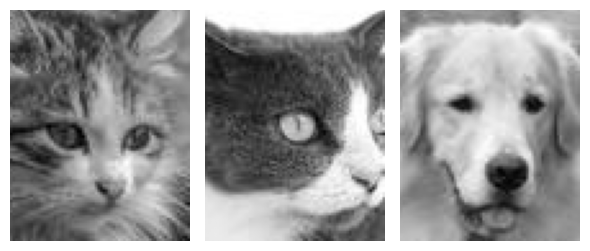

In [ ]:
# Set up the 5x10 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(6, 3))

for i, ax in enumerate(axes.flat):
    ax.imshow(new_imgs[i], cmap='grey')
    ax.set_axis_off()
plt.tight_layout()
plt.show()

We're going to do the same things as before, that is to first normalise them, then substract the mean face from them, and then flatten to a matrix.

In [ ]:
new_imgs_diff = 1/255.*new_imgs - mean_face
new_difference_matrix = new_imgs_diff.reshape(new_imgs_diff.shape[0],-1).T

#### Projection into eigen space

Now we can project our new faces into the eigen space to calculate their eigen coefficients. We can do this by taking the dot product between the eigenvectors and the new faces' difference matrix

In [ ]:
eigen_coefficients = eigenvecs_sorted.T.dot(new_difference_matrix).T

#### Plot the eigen coefficients of new faces

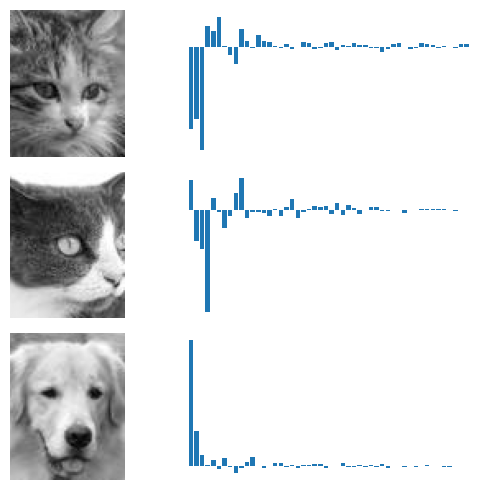

In [ ]:
# Set up the 5x10 grid for subplots
fig, axes = plt.subplots(3, 2, figsize=(6, 5))

for i, ax in enumerate(axes.flat):
    if i%2==0:
        ax.imshow(new_imgs[i//2], cmap='grey')
    else:
        ax.bar(np.arange(0,50),eigen_coefficients[i//2])
    ax.set_axis_off()
plt.tight_layout()
plt.show()

#### Comparing coefficients by $L^2$ distance  

In week 2 we mentioned comparing two vectors by $L^2$ (Euclidean) distance, now we can use it to compare the different between these three eigen coefficients.

In [ ]:
import math

In [ ]:
distance_0_1 = math.dist(eigen_coefficients[0], eigen_coefficients[1])
distance_0_2 = math.dist(eigen_coefficients[0], eigen_coefficients[2])

In [ ]:
print(f'the distance between the 1 and 2 faces is {distance_0_1}')
print(f'the distance between the 1 and 3 faces is {distance_0_2}')

the distance between the 1 and 2 faces is 2556.902343609856
the distance between the 1 and 3 faces is 5208.695402294829
